In [284]:
import pandas as pd
import dateutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as plticker

## 1. import data and data cleaning (refined)

In [12]:
#choose data source
filenames = ["2019full.csv", "2018full.csv"]

#import data to pandas data frame, with datetime parsing (using Paris local time)
dfs = []
for filename in filenames:
    df = pd.read_csv(filename,sep=';', parse_dates=[6], date_parser = dateutil.parser.parse)
    dfs.append(df)
    
df_all = pd.concat(dfs)

In [17]:
df_all.head()

,iu_ac,libelle,iu_nd_amont,libelle_nd_amont,iu_nd_aval,libelle_nd_aval,t_1h,q,k,etat_trafic,dessin
0,4618,Cours Albert 1er_VGP,163,Souterrain_Cours_la_Reine,2467,Cours_Albert_Ier-VGP,2019-06-12 03:00:00+02:00,695.0,2.06056,1,"""<PLINE><PT X=""""598038"""" Y=""""129374""""/><PT X=""..."
1,1307,Bd_Richard_Lenoir,717,Republique-Richard_Lenoir-Timbau,716,Republique-Jules_Ferry,2019-01-30 04:00:00+01:00,140.0,1.38111,1,"""<PLINE EPAISSEUR=""""6""""><PT X=""""602421"""" Y=""""1..."
2,4618,Cours Albert 1er_VGP,163,Souterrain_Cours_la_Reine,2467,Cours_Albert_Ier-VGP,2019-06-12 11:00:00+02:00,1141.0,3.64889,1,"""<PLINE><PT X=""""598038"""" Y=""""129374""""/><PT X=""..."
3,1307,Bd_Richard_Lenoir,717,Republique-Richard_Lenoir-Timbau,716,Republique-Jules_Ferry,2019-01-30 16:00:00+01:00,697.0,5.97611,1,"""<PLINE EPAISSEUR=""""6""""><PT X=""""602421"""" Y=""""1..."
4,4618,Cours Albert 1er_VGP,163,Souterrain_Cours_la_Reine,2467,Cours_Albert_Ier-VGP,2019-06-12 19:00:00+02:00,1068.0,3.26389,1,"""<PLINE><PT X=""""598038"""" Y=""""129374""""/><PT X=""..."


In [15]:
#NAs

print("Number of rows is: %d"%df_all.shape[0])
print("\nNumber of NaN in each column is:")
print(df_all.isnull().sum())

#delete rows with empty q or k (or date or street if there is missing val)
df1 = df_all.dropna(subset=['q','k'], inplace=False)

print("\n\nAfter cleaning, the updated number of rows is: %d"%df1.shape[0])
print("\nNow, the updated number of NaN in each column is:")
print(df1.isnull().sum())

Number of rows is: 35633520

Number of NaN in each column is:
iu_ac                      0
libelle                    0
iu_nd_amont                0
libelle_nd_amont           0
iu_nd_aval                 0
libelle_nd_aval            0
t_1h                       0
q                   14727478
k                   13595735
etat_trafic                0
dessin                     0
dtype: int64


After cleaning, the updated number of rows is: 17461867

Now, the updated number of NaN in each column is:
iu_ac               0
libelle             0
iu_nd_amont         0
libelle_nd_amont    0
iu_nd_aval          0
libelle_nd_aval     0
t_1h                0
q                   0
k                   0
etat_trafic         0
dessin              0
dtype: int64


In [6]:
# duplicates
duplicateRows = df1[df1.duplicated()] 
#print("Duplicate Rows except first occurrence based on all columns are :")
#print(duplicateRows)

# keep the first occurrence of the duplicates
df1.drop_duplicates(inplace=True)
df1.shape[0]

17461859

In [7]:
# outliers
df1 = df1.drop(df1[(df1.q == 0) & (df1.k <50) & (df1.k != 0)].index) #3054 records deleted
df1 = df1.drop(df1[(df1.q >20000) & (df1.k < 10)].index) # 1 record deleted

In [37]:
#unrelated columns
## delete the following street-related cols which are redundant to iu_ac:
df2 = df1.copy()
df2 = df2.drop(columns=['libelle','iu_nd_amont', 'libelle_nd_amont', 'iu_nd_aval', 'libelle_nd_aval', 'etat_trafic', 'dessin'])

In [ ]:
#df2.to_csv("all_cleaned_4col")
#df2 = pd.read_csv("all_cleaned_4col",index_col = [0])

In [8]:
df2.head()

,iu_ac,t_1h,q,k,date,year,month,day,weekday,time,holiday
0,4618,2019-06-12 03:00:00,695.0,2.06056,2019-06-12,2019,6,12,3,3,0
1,1307,2019-01-30 04:00:00,140.0,1.38111,2019-01-30,2019,1,30,3,4,0
2,4618,2019-06-12 11:00:00,1141.0,3.64889,2019-06-12,2019,6,12,3,11,0
3,1307,2019-01-30 16:00:00,697.0,5.97611,2019-01-30,2019,1,30,3,16,0
4,4618,2019-06-12 19:00:00,1068.0,3.26389,2019-06-12,2019,6,12,3,19,0


Text(0, 0.5, 'count')

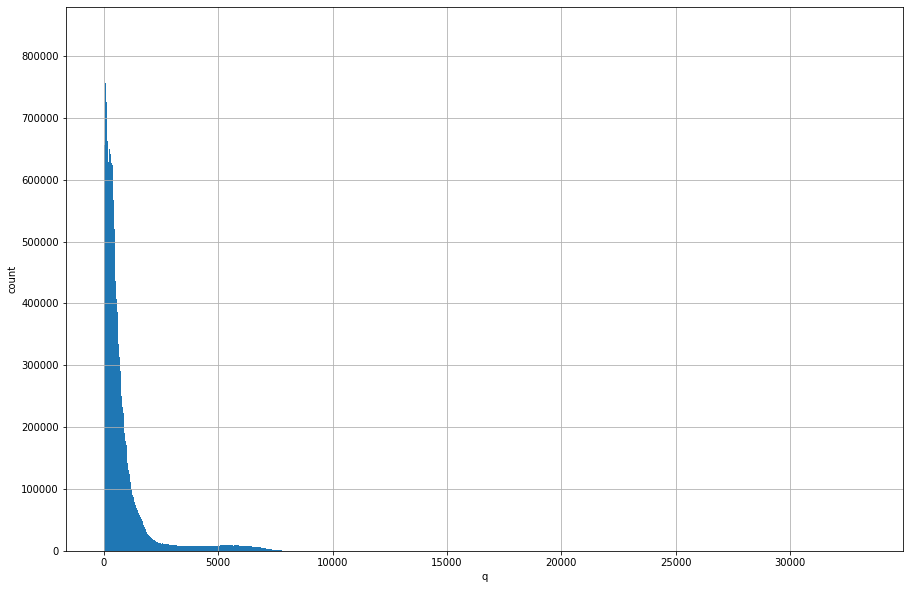

In [51]:
# histogram of q
plt.figure(figsize=(15,10))
df2.q.hist(bins=1000)
plt.xlabel("q")
plt.ylabel("count")

##### the histogram of q demonstrates that, overall, the number of records decreases as q increases; when q is greater than 2000 approximately, #records does not change significantly, except a slight increasement around q = 6000 (perhaps it's the typical capacity of grand streets in Paris).

## 2. determine polution threshold

1. We make a simplifying assumtion that pollution level at a given moment is directly proportional to the number of cars moving.


2. We make a histogram of q (number of cars per street segment and hour) and consider 4 pollution levels as follows : 
    - 0 - 25th percentile = blue
    - 25th - 50th percentile = green
    - 50th - 75th percentile = orange
    - 75th - 100th percentile = red 

In [10]:
threshold = df2.q.quantile([0.25, 0.5, 0.75, 1]).tolist()

In [33]:
print("the thresholds of polution are:")
print("BLUE: {} - {}".format('0', threshold[0]))
print("GREEN: {} - {}".format(threshold[0], threshold[1]))
print("ORANGE: {} - {}".format(threshold[1], threshold[2]))
print("RED: {} - {}".format(threshold[2], threshold[3]))

the thresholds of polution are:
BLUE: 0 - 204.0
GREEN: 204.0 - 437.0
ORANGE: 437.0 - 851.0
RED: 851.0 - 33272.0


In [130]:
print("in each quarter, there are about %d records per category (slightly different due to pandas calc method)"%(len(df2)/4))

in each quarter, there are about 4364505 records per category (slightly different due to pandas calc method)


## 3. current polution status (2019)

In [11]:
# add a column indicating the polution status
quantiles, bins = pd.qcut(df2['q'], 4, labels=["b", "g", "o", "r"], retbins = True) #labels: b for blue, g for green, o for orange, r for red
df2 = df2.assign(polution_2019 = quantiles.values)

In [128]:
len(df2[df2.polution_2019 == "g"])

4366097

## 4. generate future traffic flow / polution status (2020)

3. We assume that N = 1.06 the number of passengers per vehicle currently (number derived from article in Les Echos http://archives.lesechos.fr/archives/cercle/2016/01/28/cercle_147584.htm) . 


4. We consider a future scenario A where we succeed in motivating citizens to share vehicles and use less individually driven cars. Now, let N = 1.50.  (again, a number from the same article, projected for 2020.)


5. We apply this information on q and compute the hypothetical value of q, say, q_A = 1.06 x q / 1.50 = 0.71 q, corresponding to scenario A. (Assuming nb. of total passengers remains the same.)


In [12]:
#traffic flow in future
df2['q_2020'] = round(0.71 * df2['q'])

In [13]:
#polution level in future
quantiles_2020 = pd.cut(df2['q_2020'], bins = bins, labels=["b", "g", "o", "r"])
df2 = df2.assign(polution_2020 = quantiles_2020.values)

In [14]:
df2.head()

,iu_ac,t_1h,q,k,date,year,month,day,weekday,time,holiday,polution_2019,q_2020,polution_2020
0,4618,2019-06-12 03:00:00,695.0,2.06056,2019-06-12,2019,6,12,3,3,0,o,493.0,o
1,1307,2019-01-30 04:00:00,140.0,1.38111,2019-01-30,2019,1,30,3,4,0,b,99.0,b
2,4618,2019-06-12 11:00:00,1141.0,3.64889,2019-06-12,2019,6,12,3,11,0,r,810.0,o
3,1307,2019-01-30 16:00:00,697.0,5.97611,2019-01-30,2019,1,30,3,16,0,o,495.0,o
4,4618,2019-06-12 19:00:00,1068.0,3.26389,2019-06-12,2019,6,12,3,19,0,r,758.0,o


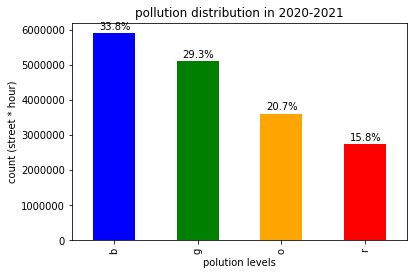

In [282]:
ax = pd.value_counts(df2['polution_2020']).plot.bar(color = ['b','g','orange','r'])
plt.title('pollution distribution in 2020-2021')
plt.xlabel('polution levels')
plt.ylabel('count (street * hour)')
total = len(df2['polution_2020'])
for p in ax.patches:
    percentage = 100 * p.get_height()/total
    if percentage > 0:
        percentage = '{:.1f}%'.format(percentage)
        x = p.get_x() + p.get_width()/7
        y = p.get_y() + p.get_height()+100000
        ax.annotate(percentage, (x, y))


#### the #records decreases as the polution level increases in future

## 5. hypothetical improvement in pollution level

6. We apply the same thresholds as in step 2, and consider the hypothetical improvement in pollution level, i.e. % of street segment x hour which moved from red to orange, from red to green, from orange to green, etc. 

In [15]:
p19 = pd.DataFrame(df2['polution_2019'].value_counts().reset_index().values, columns = ["polution", "count_2019"])
p20 = pd.DataFrame(df2['polution_2020'].value_counts().reset_index().values, columns = ["polution", "count_2020"])
polution_count = pd.merge(p19, p20, on='polution')

Text(0, 0.5, 'count')

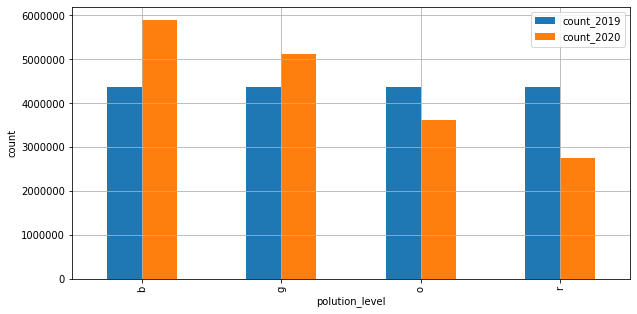

In [140]:
#compare polution in 2018-2019 vs 2020-2021
#plt.figure(figsize=(15,10))

polution_count.set_index('polution').plot(kind = "bar", figsize=(10,5), grid=True)
plt.xlabel("polution_level")
plt.ylabel("count")

#### in 2018-2019, each quarter has 436,4505 records; in 2020-2021, #records in blue and green will increase and orange and red will decrease based on our estimation

In [16]:
#create a column indicating the polution change
df2['polution_change'] = df2['polution_2019'].str.cat(df2['polution_2020'], sep = "-")

In [17]:
change = pd.DataFrame(df2['polution_change'].value_counts().reset_index().values, columns = ['change_type', 'count']).set_index('change_type')
print("there are {} types of change:".format(len(change)))
print(change)

there are 7 types of change:
               count
change_type         
b-b          4295380
g-g          2758289
r-r          2754181
o-g          2355835
o-o          2006302
g-b          1607808
r-o          1605630


In [18]:
change = change.reindex(['b-b', 'g-g', 'o-o','r-r', 'r-o', 'o-g', 'g-b'])

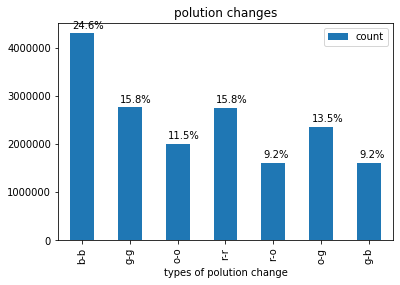

In [187]:
#plot polution change (street * hour)
ax = change.plot(kind = "bar")
plt.title('polution changes')
plt.xlabel('types of polution change')

total = len(df2['polution_change'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/10
        y = p.get_y() + p.get_height() + 100000
        ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
change['2019'] = change.index.str.slice(0, 1)
change = change.set_index('2019')

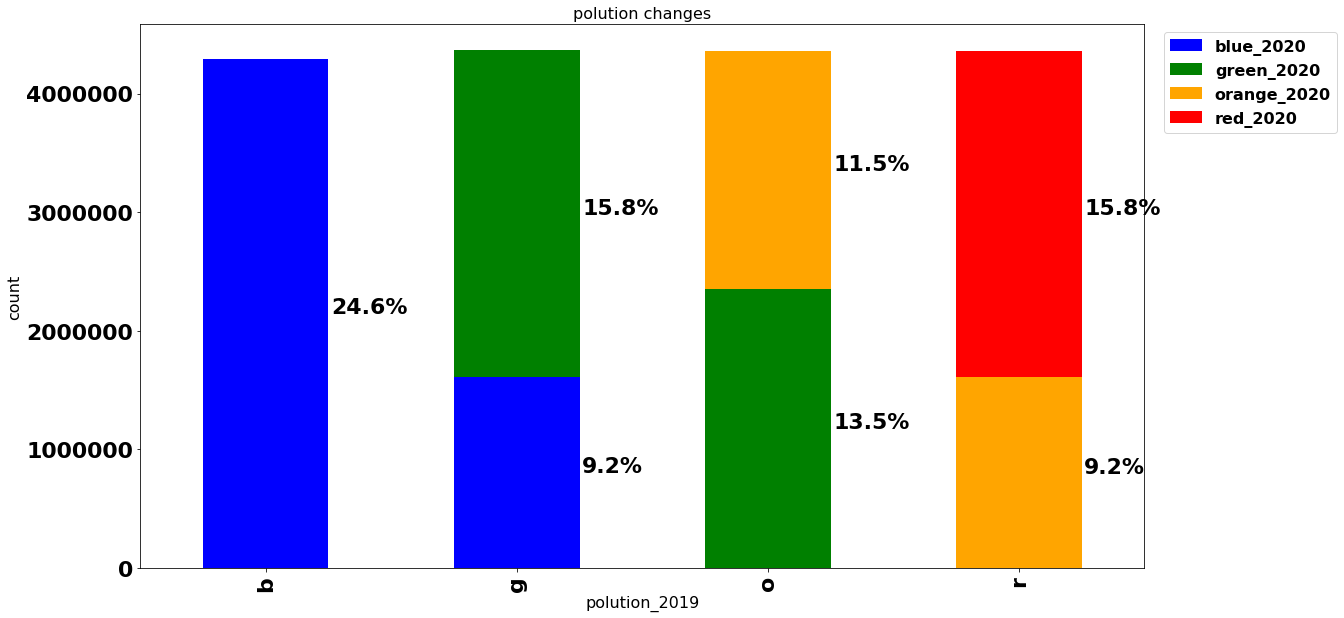

In [291]:
#df_plot = df2.groupby(['polution_2020','polution_2019']).size().reset_index().pivot(columns='polution_2020', index='polution_2019', values=0)

ax = df_plot.plot(kind='bar', stacked=True, figsize = (18,10), color = ['b', 'g', 'orange', 'r'])
ax.legend(["blue_2020", "green_2020", "orange_2020", "red_2020"],bbox_to_anchor=(1.2, 1),fontsize = 16)
ax.set_ylabel('count',fontsize=16)
ax.set_xlabel('polution_2019' , fontsize=16)

plt.title('polution changes',fontsize=16)

total = len(df2['polution_2019'])
for p in ax.patches:
        percentage = 100 * p.get_height()/total
        if percentage > 0:
            percentage = '{:.1f}%'.format(percentage)
            x = p.get_x() + p.get_width()+0.01
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

plt.show()

### Boulevard Haussmann 

In [175]:
haussmann_id = df[df['libelle'] == "Bd_Haussmann"].iu_ac.unique().tolist()
haussmann_id

[1947, 4226, 6019, 1945, 4229, 5743, 1946, 4228, 6013, 6018, 4230]

In [178]:
haussmann = df2[df2.iu_ac.isin(haussmann_id)]
haussmann.head()

,iu_ac,t_1h,q,k,date,year,month,day,weekday,time,holiday,polution_2019,q_2020,polution_2020,polution_change
639,1947,2019-01-29 14:00:00,2472.0,1.03222,2019-01-29,2019,1,29,2,14,0,r,1755.0,r,r-r
641,1947,2019-01-30 06:00:00,1164.0,0.04278,2019-01-30,2019,1,30,3,6,0,r,826.0,o,r-o
643,1947,2019-01-30 08:00:00,1089.0,0.19722,2019-01-30,2019,1,30,3,8,0,r,773.0,o,r-o
1558,4226,2019-06-15 20:00:00,691.0,4.63000,2019-06-15,2019,6,15,6,20,0,o,491.0,o,o-o
1560,4226,2019-06-18 17:00:00,694.0,8.41945,2019-06-18,2019,6,18,2,17,0,o,493.0,o,o-o


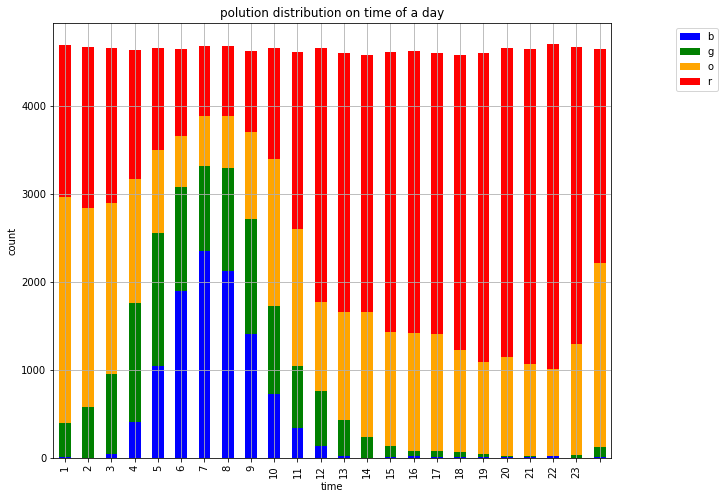

In [210]:
#polution distribution on time of a day
haussmann_dplot = haussmann.groupby(['polution_2019','time']).size().reset_index().pivot(columns='polution_2019', index='time', values=0)

ax = haussmann_dplot.plot(kind='bar', stacked=True, figsize = (10,8), grid = True, color = ['b', 'g', 'orange', 'r'])
ax.legend(bbox_to_anchor=(1.2, 1))
ax.set_ylabel('count')

plt.title('polution distribution on time of a day')


loc = plticker.MultipleLocator(base=1.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

Text(0.5, 1.0, 'polution changes of Bd.Haussmann')

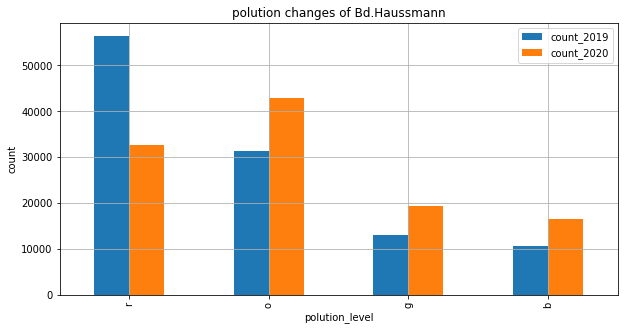

In [181]:
h19 = pd.DataFrame(haussmann['polution_2019'].value_counts().reset_index().values, columns = ["polution", "count_2019"])
h20 = pd.DataFrame(haussmann['polution_2020'].value_counts().reset_index().values, columns = ["polution", "count_2020"])
polution_count_h = pd.merge(h19, h20, on='polution')

#compare polution in 2018-2019 vs 2020-2021

polution_count_h.set_index('polution').plot(kind = "bar", figsize=(10,5), grid=True)
plt.xlabel("polution_level")
plt.ylabel("count")
plt.title('polution changes of Bd.Haussmann')

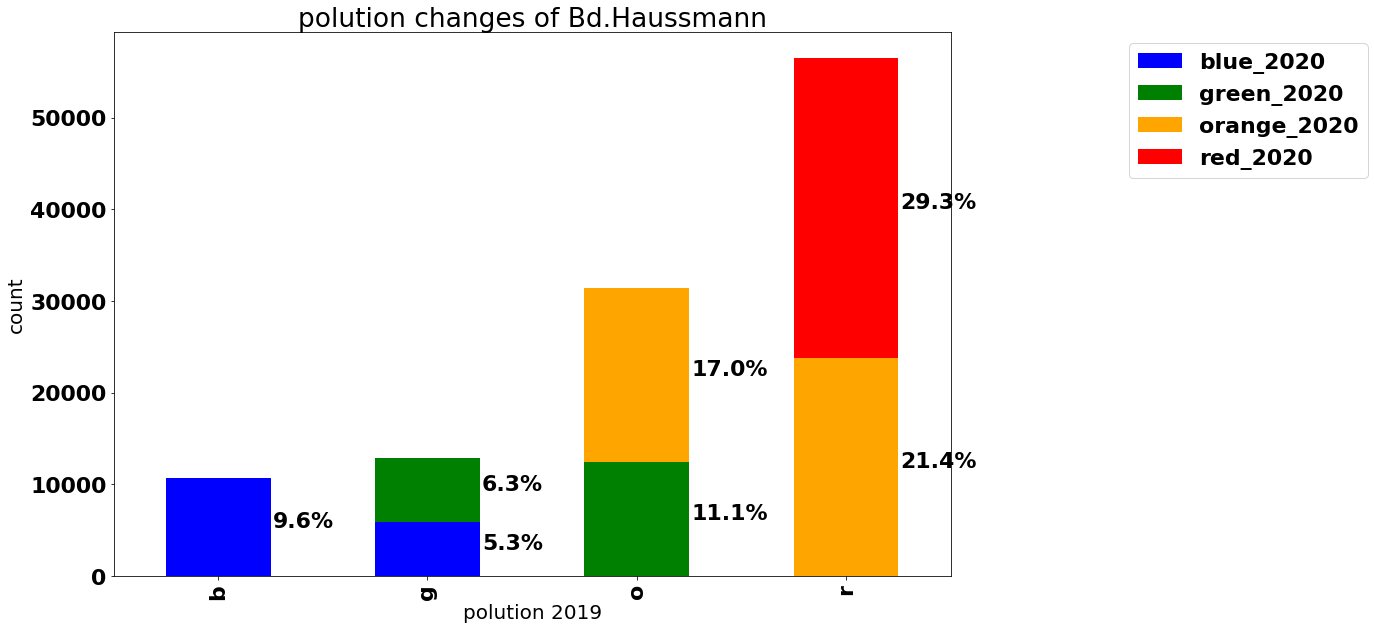

In [293]:
haussmann_plot = haussmann.groupby(['polution_2020','polution_2019']).size().reset_index().pivot(columns='polution_2020', index='polution_2019', values=0)

ax = haussmann_plot.plot(kind='bar', stacked=True, figsize = (15,10), color = ['b', 'g', 'orange', 'r'])
ax.legend(["blue_2020", "green_2020", "orange_2020", "red_2020"],bbox_to_anchor=(1.2, 1))
ax.set_ylabel('count',fontsize = 20)
ax.set_xlabel('polution 2019',fontsize = 20)

plt.title('polution changes of Bd.Haussmann')

total = len(haussmann['polution_2019'])
for p in ax.patches:
        percentage = 100 * p.get_height()/total
        if percentage > 0:
            percentage = '{:.1f}%'.format(percentage)
            x = p.get_x() + p.get_width()+0.01
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

plt.show()

### compare with Champs-Elysees

In [194]:
champselysees_id = df[df['libelle'] == "Av_Champs_Elysees"].iu_ac.unique().tolist()
champselysees = df2[df2.iu_ac.isin(champselysees_id)]

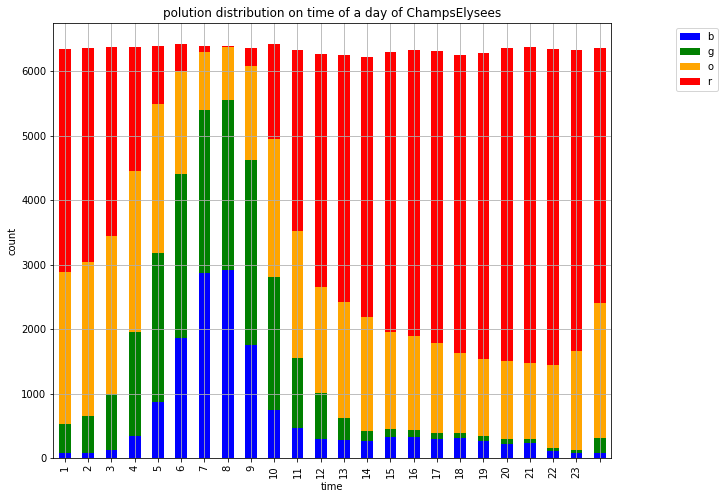

In [212]:
#polution distribution on time of a day
champselysees_dplot = champselysees.groupby(['polution_2019','time']).size().reset_index().pivot(columns='polution_2019', index='time', values=0)

ax = champselysees_dplot.plot(kind='bar', stacked=True, figsize = (10,8), grid = True, color = ['b', 'g', 'orange', 'r'])
ax.legend(bbox_to_anchor=(1.2, 1))
ax.set_ylabel('count')

plt.title('pollution distribution on time of a day of ChampsElysees')


loc = plticker.MultipleLocator(base=1.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

Text(0.5, 1.0, 'pollution changes of ChampsElysees')

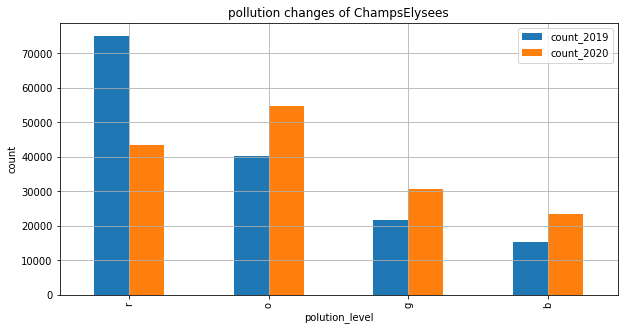

In [268]:
c19 = pd.DataFrame(champselysees['polution_2019'].value_counts().reset_index().values, columns = ["polution", "count_2019"])
c20 = pd.DataFrame(champselysees['polution_2020'].value_counts().reset_index().values, columns = ["polution", "count_2020"])
polution_count_c = pd.merge(c19, c20, on='polution')

#compare polution in 2018-2019 vs 2020-2021

polution_count_c.set_index('polution').plot(kind = "bar", figsize=(10,5), grid=True)
plt.xlabel("polution_level")
plt.ylabel("count")
plt.title('pollution changes of ChampsElysees')

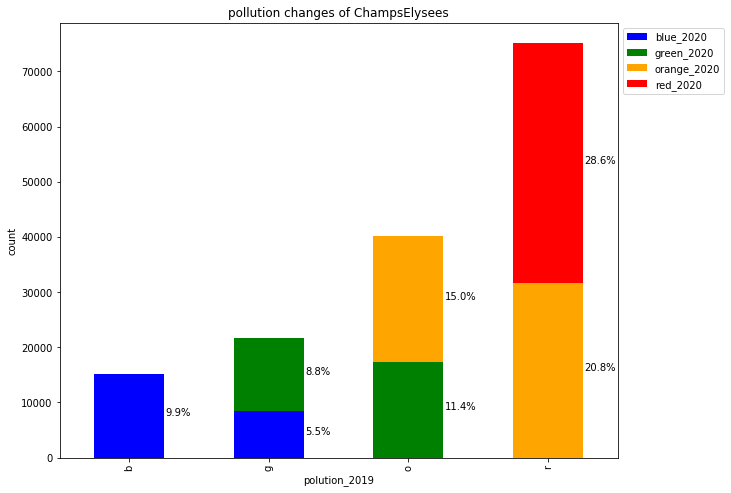

In [269]:
champselysees_plot = champselysees.groupby(['polution_2020','polution_2019']).size().reset_index().pivot(columns='polution_2020', index='polution_2019', values=0)

ax = champselysees_plot.plot(kind='bar', stacked=True, figsize = (10,8), color = ['b', 'g', 'orange', 'r'])
ax.legend(["blue_2020", "green_2020", "orange_2020", "red_2020"],bbox_to_anchor=(1.2, 1))
ax.set_ylabel('count')

plt.title('pollution changes of ChampsElysees')

total = len(champselysees['polution_2019'])
for p in ax.patches:
        percentage = 100 * p.get_height()/total
        if percentage > 0:
            percentage = '{:.1f}%'.format(percentage)
            x = p.get_x() + p.get_width()+0.01
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

plt.show()

### Top 10 streets with most improvement

In [ ]:
#Top 10 streets with most improvement
df2['change'][df2.polution_2019 != df2.polution_2020] = 1

In [257]:
top = pd.DataFrame(df2.groupby(['change','iu_ac']).size(), columns = ['count'])

In [267]:
#we assume each street has approximately same number of records for now, then we look for the streets with the most changes
top.sort_values(['change','count'],ascending=False).head(10)

count
change iu_ac       
1      6557    7838
       1558    7819
       1640    7748
       1642    7731
       1644    7723
       1638    7634
       1646    7392
       1679    7317
       820     7124
       1562    7071